In [1]:
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
filename = 'data/raw_text/aesop_fable.txt'

with open(filename, 'r') as f:
    raw_text = f.read()

In [3]:
print(raw_text[:100])

The Wolf And The Lamb

WOLF, meeting with a Lamb astray from the fold, resolved not to lay
violent 


In [4]:
new_story_token = '| ' * 20

In [5]:
text = new_story_token + raw_text
text = text.lower()
text = text.replace('\n\n\n\n\n', new_story_token)
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text)
text = re.sub('\s{2,}', ' ', text)

In [6]:
print(text[:100])

 | | | | | | | | | | | | | | | | | | | | ﻿the wolf and the lamb . wolf , meeting with a lamb astray 


In [7]:
tokenizer = Tokenizer(char_level=False, filters='')
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1
token_list = tokenizer.texts_to_sequences([text])[0]

In [8]:
print(total_words)
print(list(tokenizer.word_index.items())[:10])

5921
[('|', 1), (',', 2), ('the', 3), ('.', 4), ('and', 5), ('of', 6), ('a', 7), ('to', 8), ('his', 9), ('in', 10)]


In [9]:
from keras.utils import np_utils

def generate_sequences(token_list, seq_length, step):
    x = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        x.append(token_list[i: i + seq_length])
        y.append(token_list[i + seq_length])
    
    y = np_utils.to_categorical(y, num_classes=total_words)

    num_sequences = len(x)
    print(f'Number of sequences: {num_sequences}')

    return x, y, num_sequences

step = 1
seq_length = 20
x, y, num_sequences = generate_sequences(token_list, seq_length, step)

Number of sequences: 57689


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(x), np.asarray(y), test_size=0.25, random_state=42)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


def model_fn(hp):
    hp_n_units = hp.Int('n_units', min_value=64, max_value=256, step=64)
    hp_embedding = hp.Float('embedding_size', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.0001, step=0.00004)

    input_layer = Input(shape=(seq_length,))
    embedding_layer = Embedding(total_words, hp_embedding)(input_layer)
    bi_gru_layer = Bidirectional(GRU(hp_n_units))(embedding_layer)
    dropout_layer = Dropout(hp_dropout)(bi_gru_layer)
    dense_layer = Dense(total_words, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=dense_layer)

    optimizer = RMSprop(learning_rate=hp_learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model


In [12]:
import keras_tuner as kt


tuner = kt.Hyperband(model_fn,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='tuning',
                     project_name='text_generation',
                     seed=42)


INFO:tensorflow:Reloading Oracle from existing project tuning/text_generation/oracle.json


2021-11-13 16:55:20.587589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 16:55:20.592547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 16:55:20.592879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 16:55:20.593728: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Reloading Tuner from tuning/text_generation/tuner0.json


In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', patience=3)
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early], shuffle=True)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
n_units {best_hps.get('n_units')}
embedding_size {best_hps.get('embedding_size')}
dropout_rate {best_hps.get('dropout_rate')}
learning_rate {best_hps.get('learning_rate')}
""")


INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
n_units 256
embedding_size 100
dropout_rate 0.30000000000000004
learning_rate 9e-05



In [14]:
# supress INFO and Warning messages https://github.com/tensorflow/tensorflow/issues/47554
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model', monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1, save_format='tf')

model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=32, epochs=100, shuffle=True, verbose=0, callbacks=[es, mc])


2021-11-13 16:55:39.622190: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2021-11-13 16:55:40.109488: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 00001: val_loss improved from inf to 5.68445, saving model to best_model


2021-11-13 16:55:49.765000: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00002: val_loss improved from 5.68445 to 5.57886, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00003: val_loss improved from 5.57886 to 5.42845, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00004: val_loss improved from 5.42845 to 5.34555, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00005: val_loss did not improve from 5.34555

Epoch 00006: val_loss improved from 5.34555 to 5.30653, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00007: val_loss improved from 5.30653 to 5.26303, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00008: val_loss did not improve from 5.26303

Epoch 00009: val_loss improved from 5.26303 to 5.22381, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00010: val_loss improved from 5.22381 to 5.19754, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00011: val_loss improved from 5.19754 to 5.15796, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00012: val_loss did not improve from 5.15796

Epoch 00013: val_loss improved from 5.15796 to 5.14201, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00014: val_loss improved from 5.14201 to 5.12927, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00015: val_loss did not improve from 5.12927

Epoch 00016: val_loss did not improve from 5.12927

Epoch 00017: val_loss improved from 5.12927 to 5.10050, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00018: val_loss improved from 5.10050 to 5.09391, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00019: val_loss did not improve from 5.09391

Epoch 00020: val_loss did not improve from 5.09391

Epoch 00021: val_loss improved from 5.09391 to 5.09019, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00022: val_loss did not improve from 5.09019

Epoch 00023: val_loss did not improve from 5.09019

Epoch 00024: val_loss did not improve from 5.09019

Epoch 00025: val_loss improved from 5.09019 to 5.08068, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00026: val_loss did not improve from 5.08068

Epoch 00027: val_loss did not improve from 5.08068

Epoch 00028: val_loss improved from 5.08068 to 5.07791, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 00029: val_loss did not improve from 5.07791

Epoch 00030: val_loss did not improve from 5.07791

Epoch 00031: val_loss did not improve from 5.07791

Epoch 00032: val_loss did not improve from 5.07791

Epoch 00033: val_loss did not improve from 5.07791
Epoch 00033: early stopping


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

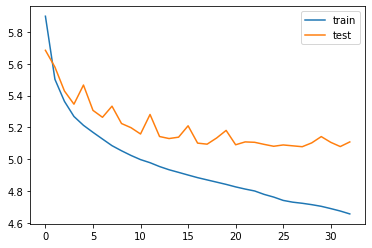

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
def sample_with_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def generate_text(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text

    seed_text = new_story_token + seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))

        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature=temp)

        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class]

        if output_word == "|":
            break

        output_text += output_word + ' '
        seed_text += output_word + ' '

    return output_text


In [22]:
seed_text = "the frog and the snake jumped over "
gen_words = 50
temp = 1.0

print (generate_text(seed_text, gen_words, model, seq_length, temp))



the frog and the snake jumped over the suffering . his with shepherd , the jupiter temples library to his fox , it partridge to the puerile horns . the thought , to adviser his ground , the ass to be whiten , beauty . a “if to these permitted , great inquired full saw to him 
